In [1]:
from DCGAN.networks import Gen, Disc, weights_init
from util import condense_range, expand_range
import torch
import torch.nn as nn
from torch.autograd import Variable, grad
import torch.functional as f
import torchvision

In [2]:
import matplotlib.pyplot as plot
%matplotlib inline

In [3]:
#parameters
batch_size = 32
n_epochs = 100

In [4]:
#Create Generator and Discriminator
G = Gen()
D = Disc(batch_size)

weights_init(G)
weights_init(D)

G = G.cuda()
D = D.cuda()

opt_G = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
criterion = nn.BCELoss()

In [5]:
def gradient_penalty(x, f):
    # interpolation
    shape = [x.size(0)] + [1] * (x.dim() - 1)
    alpha = (torch.rand(shape)).cuda()
    beta = (torch.rand(x.size())).cuda()

    y = x + 0.5 * x.std() * beta
    z = x + alpha * (y - x)

    # gradient penalty
    z = (Variable(z, requires_grad=True)).cuda()
    o = f(z)
    g = grad(o, z, grad_outputs=(torch.ones(o.size())).cuda(), create_graph=True)[0].view(z.size(0), -1)
    gp = ((g.norm(p=2, dim=1) - 1)**2).mean()

    return gp

In [6]:
#data
data = torchvision.datasets.ImageFolder('./danbooru/data/dan_chibi', transform = torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)

In [14]:
def sample():
    noise = torch.randn(1, 100, 1, 1).cuda()
    fake = condense_range(G(noise))
    img = fake.cpu().data.reshape(1, 128, 128, 3)    
    plot.imshow(img[0])
    torchvision.utils.save_image(fake, "test.png")

In [13]:
REAL = 1
FAKE = 0

for n in range(n_epochs):
    for img, _ in loader:
        #Update D
        D.zero_grad()
        X = Variable(img).cuda()
        
        label = torch.full((batch_size, 1), REAL).cuda()
        output = D(X)
        err_real = criterion(output, label)
        err_real.backward()
        D_x = output.mean().item()
        
        #Train with fake
        noise = torch.randn(batch_size, 100, 1, 1).cuda()
        fake = condense_range(G(noise))
        label = torch.full((batch_size, 1), FAKE).cuda()
        output = D(fake.detach())
        err_fake = criterion(output, label)
        err_fake.backward()
        D_g_x = output.mean().item()
        
        gp = gradient_penalty(X.data, D)
        gp.backward()
        
        err_D = err_real + err_fake
        opt_D.step()
        
        
        
        
        #Update generator
        G.zero_grad()
        label = torch.full((batch_size, 1), REAL).cuda()
        output = D(fake)
        err_G = criterion(output, label)
        err_G.backward()
        D_g_z = output.mean().item()
        opt_G.step()
        
        
    print("Discriminator loss: ", err_D + gp)
    print("Generator Loss: ", err_G)

Discriminator loss:  tensor(0.3386, device='cuda:0')
Generator Loss:  tensor(4.1295, device='cuda:0')
Discriminator loss:  tensor(0.3781, device='cuda:0')
Generator Loss:  tensor(4.2571, device='cuda:0')
Discriminator loss:  tensor(0.3734, device='cuda:0')
Generator Loss:  tensor(4.1755, device='cuda:0')
Discriminator loss:  tensor(0.7313, device='cuda:0')
Generator Loss:  tensor(7.5033, device='cuda:0')
Discriminator loss:  tensor(0.3976, device='cuda:0')
Generator Loss:  tensor(3.2524, device='cuda:0')
Discriminator loss:  tensor(1.2599, device='cuda:0')
Generator Loss:  tensor(6.2708, device='cuda:0')
Discriminator loss:  tensor(0.6200, device='cuda:0')
Generator Loss:  tensor(2.7184, device='cuda:0')
Discriminator loss:  tensor(0.9510, device='cuda:0')
Generator Loss:  tensor(7.1249, device='cuda:0')
Discriminator loss:  tensor(0.5633, device='cuda:0')
Generator Loss:  tensor(5.1268, device='cuda:0')
Discriminator loss:  tensor(0.4859, device='cuda:0')
Generator Loss:  tensor(3.748

Discriminator loss:  tensor(0.4047, device='cuda:0')
Generator Loss:  tensor(3.7874, device='cuda:0')
Discriminator loss:  tensor(0.3390, device='cuda:0')
Generator Loss:  tensor(4.8535, device='cuda:0')
Discriminator loss:  tensor(0.6765, device='cuda:0')
Generator Loss:  tensor(3.6552, device='cuda:0')
Discriminator loss:  tensor(0.4786, device='cuda:0')
Generator Loss:  tensor(5.3025, device='cuda:0')
Discriminator loss:  tensor(0.5090, device='cuda:0')
Generator Loss:  tensor(4.3660, device='cuda:0')
Discriminator loss:  tensor(0.6463, device='cuda:0')
Generator Loss:  tensor(5.8146, device='cuda:0')
Discriminator loss:  tensor(0.7995, device='cuda:0')
Generator Loss:  tensor(6.2288, device='cuda:0')
Discriminator loss:  tensor(0.5441, device='cuda:0')
Generator Loss:  tensor(2.4717, device='cuda:0')
Discriminator loss:  tensor(0.2923, device='cuda:0')
Generator Loss:  tensor(5.5139, device='cuda:0')
Discriminator loss:  tensor(0.3626, device='cuda:0')
Generator Loss:  tensor(3.336

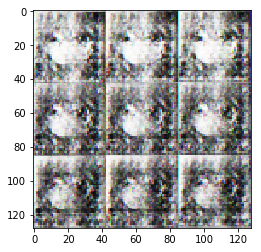

In [15]:
sample()